# 1. Sentiment in text

- The first thing when dealing with natural language, the same as when dealing with all other data is to turn it into __numbers__.
- How do you understand the meaning of a word with numbers? For example, you could take the number of the alphabet each letter occurs and use that string of numbers to understand it.
    - Listen → 12, 9, 19, 20, 5, 14
    - Silent → 19, 9, 12, 5, 14, 20
        - This approach doesn't work that well. These two words have opposite meanings but contain the same numbers.
- What about a word based encodings? For example:
    - I love my dog → 1, 2, 3, 4
    - I love my cat → 1, 2, 3, 5
        - This approach is starting to get better since the first 3 words have the same numbers.

🔑 Turning words into numbers is known as Tokenizing, Keras includes this functionality in the Tokenizer class.

In [26]:
#example to creae tokens for words 
import tensorflow as tf 
from tensorflow import keras 
from keras.preprocessing.text import Tokenizer

list_1 = {'i love my dog',
         'You love my Dog!'}
#order of tokens - based on the occurances of word in entire object 

#Note - to convert words into text use Tokenizer
tokenizer = Tokenizer(num_words=5) #instatiate 
tokenizer.fit_on_texts(list_1)     #fit tokenizer on texts 
#now to create a sequence of tokens with respect to texts from list_1
sequence = tokenizer.texts_to_sequences(list_1)
print("Running tokenizer over the text:")
print(sequence)

#if you want to see the text and their index in tokenizer
word_index = tokenizer.word_index
print('\nTokenized words:')
print(word_index)

#you have actually create a small text detector- if you want to detect the text in some other object you can do so my using the previously trained tokenizer
test_1 = ['You love my Dog and cat']

test_sequence = tokenizer.texts_to_sequences(test_1)
print("\nOutput of the unseen text:")
print(test_sequence)
print("Unknown texts are eliminated")

#now if you want to have the vlaues that were not found in your tokenized dictionary included - initiate oov_val 
tokenizer = Tokenizer(num_words=5, oov_token= '<OOV>') #instatiate 
tokenizer.fit_on_texts(list_1)     #fit tokenizer on texts 
sequence = tokenizer.texts_to_sequences(list_1)

test_sequence = tokenizer.texts_to_sequences(test_1)
print("\nOutput of the unseen text after including out of vocabulary param:")
print(test_sequence)
word_index_new = tokenizer.word_index
print("word_index after including oov:",word_index_new )


Running tokenizer over the text:
[[4, 1, 2, 3], [1, 2, 3]]

Tokenized words:
{'love': 1, 'my': 2, 'dog': 3, 'you': 4, 'i': 5}

Output of the unseen text:
[[4, 1, 2, 3]]
Unknown texts are eliminated

Output of the unseen text after including out of vocabulary param:
[[1, 2, 3, 4, 1, 1]]
word_index after including oov: {'<OOV>': 1, 'love': 2, 'my': 3, 'dog': 4, 'you': 5, 'i': 6}


##### Now you know how to encode word into tokens, you still can't pass the data directly to NN __(because if the sizes are not compatible there will be a size mismatch)__

- 🔑 **Padding** is used to make sure all sequences are the same length. That way when passed to a neural network, the matrices it accepts as input are all a uniform size.
- Example padding code:

In [27]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded = pad_sequences(sequence, maxlen=6, padding='pre', truncating='pre' )
print("this is how the padding two will affect the line of 4 words:", padded)

this is how the padding two will affect the line of 4 words: [[0 0 1 2 3 4]
 [0 0 1 2 3 4]]


# 2. Word embeddings 

- Word embeddings is a way of turning your words into numbers which is better than simply labelling words in your vocabulary from 1 to 10,000 (if you've got 10,000 different words)

In [28]:
pip install tensorflow_datasets

Note: you may need to restart the kernel to use updated packages.


# 3.  let's start building NN for IMDB_reviews dataset 

In [30]:
import tensorflow_datasets as tfds 

In [31]:
imdb, info = tfds.load("imdb_reviews", with_info= True, as_supervised= True)

In [42]:
train = imdb['train'] 
test = imdb['test']

In [35]:
train_sentences= []
train_labels = []
test_sentences = []
test_labels = []

In [44]:
import numpy as np

for s,l in train:
    train_sentences.append(s.numpy().decode('utf-8'))
    train_labels.append(l.numpy())
    
for s,l in test:
    test_sentences.append(s.numpy().decode('utf-8'))
    test_labels.append(l.numpy()) 

train_labels_final = np.array(train_labels)
test_labels_final = np.array(test_labels)

#now you have crerated a data fro training and testing 

In [50]:
print(train_sentences[0]) #this is one of the sentences 
print(len(train_sentences)) #there are around 75000 entries for training 
print(train_labels[0]) # this shows positive or negative review 
print(len(test_sentences)) #there are around 50000 entries for testing 

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
75000
0
50000


In [51]:
# let's now instantiate a tokenizer and convert the words into numbers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#let's tune some hyperparameters 
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

#input data - train_sequence

tokenizer = Tokenizer(num_words= vocab_size)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

# convert text to sequences 
sequences = tokenizer.texts_to_sequences(train_sentences)
#introducing padding for same length inputs for NN 
padded = pad_sequences(sequences, maxlen = max_length, padding = 'pre', truncating= trunc_type)


#moving the toeknizer on the testing set 
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padding = pad_sequences(test_sequences, maxlen = max_length, padding = 'pre', truncating= trunc_type )

In [52]:
#checking the sizes before feeding it to model 
print(len(padded), len(train_labels_final))
print(len(test_padding), len(test_labels_final))

75000 75000
50000 50000


In [56]:
#building a model architecture 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    #tf.keras.layers.Flatten() -- I can use this as well but in case of texts we normally make use of GlobalAveragePooling1D(), only advantage is that the computations might be a little fasters becasue of less number of paramters involved 
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation = 'relu'),
    tf.keras.layers.Dense(1, activation ='sigmoid')
])

#print summary of model 
model.summary()

#compile your model since this is a binary classifcation hence we use binary_crossentropy to measure_loss 
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
              metrics = ['acc'])

#fitting and validating the model
history = model.fit(
                    padded, 
                    train_labels_final, 
                    epochs = 30,
                    validation_data = (test_padding, test_labels_final), 
                    verbose = 2
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 160,109
Trainable params: 160,109
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
2344/2344 - 4s - loss: 0.3753 - acc: 0.8421 - val_loss: 0.3743 - val_acc: 0.8352
Epoch 2/30
2344/2344 - 3s - loss: 0.1999 - acc: 0.9261 - val_loss: 0.4455 - val_acc: 0.8250
Epoch 3/30
2344/2344 - 3s - loss: 0.1450 - acc: 0.9506 - val_los

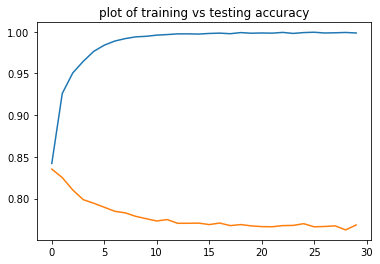

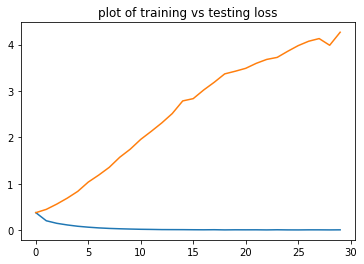

In [57]:
#printing training and testing accuracy and loss over the epochs 
import matplotlib.pyplot as plt 

train_acc= history.history['acc']
test_acc = history.history['val_acc']
train_loss = history.history['loss']
test_loss= history.history['val_loss']

epochs = range(len(train_acc))

plt.plot(epochs , train_acc, label = "training acc")
plt.plot(epochs , test_acc, label = "training acc")
plt.title("plot of training vs testing accuracy")
plt.figure()

plt.plot(epochs , train_loss, label = "training loss")
plt.plot(epochs , test_loss, label = "training loss")
plt.title("plot of training vs testing loss")
plt.show()

- This kind of model will push towards 100% accuracy on the training set which is a strong indication of overfitting.
- 🔑 When you're working with text data, you might find the validation loss increases as training goes on.
    - Think of this as the confidence of the models prediction on a particular sample.
    - One of the ways you can monitor it is to explore the differences in metrics as you tweak hyperparameters, such as embedding size, vocab size, etc.

In [59]:
#now as you know words are stored as a key and their value is stored as numbers 
# we will reverse that by creating a function 
reverse_word_index = dict([(value, key) for (key,value) in word_index.items()])

def decode_function(text):
    return " ".join( [reverse_word_index.get(i,"?") for i in text])

# join strings with space 
#(Return the value for key if key is in the dictionary, else default)
# for padded 0 the value are comng as default

In [62]:
#getting the weights from the embedded layers 

e = model.layers[0]
weights = e.get_weights()[0]
print(len(weights))

10000


In [67]:
import os 

In [68]:
os.chdir("/Users/avinashtripathi/Downloads")

In [75]:
print(embeddings)

[-0.00903783 -0.03351708 -0.09210564  0.27004948  0.01863869 -0.05287478
  0.04094364  0.06962577  0.00030145 -0.01108484 -0.05415261 -0.01984923
  0.00094745 -0.00609331  0.0380161   0.02291058]


In [72]:
#creating vector and meta files
import io

out_v = io.open('vecs.tsv', 'w', encoding ='utf-8')
out_m = io.open('meta.tsv', 'w', encoding= 'utf-8')

for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")

out_v.close()
out_m.close()

#this will output the vector and metadeta file and you can upload the filesto plot the words based 
#on their embedding weights https://projector.tensorflow.org/

http://localhost:8888/view/Desktop/embedding1.png - final result 

# 4. Performing embedding on sarcasm.json 
-  https://drive.google.com/uc?id=1xRU3xY5-tkiPGvlz5xBJ18_pHWSRzI4v

In [76]:
#sarcasm.json 
import json

In [77]:
with open('sarcasm.json', 'r') as f:
    datastore = json.load(f)

In [78]:
len(datastore)

26709

In [79]:
#creating a list of training and testing data 
sentences = []
labels = []
urls = []


for file in datastore:
    sentences.append(file['headline']) 
    labels.append(file['is_sarcastic']) 
    urls.append(file['article_link'])

In [80]:
#setting up the hyperparameter 
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

training_sentences =sentences[:training_size]
testing_sentences =sentences[training_size:]
print(testing_sentences[1])
training_labels =labels[:training_size]
testing_labels = labels[training_size:]


don't rely on your fitness tracker to lose weight


In [81]:
#creating tokens for the training and testing samples 
import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok) #first 10000 most occured words will be tokenized 
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences ,maxlen= max_length, truncating = trunc_type, padding= padding_type)
print(len(padded[1]))
print(padded[1])

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen= max_length, truncating = trunc_type, padding= padding_type)

100
[   4 6840 3096 3097   23    2  161    1  390 2842    6  251    9  889
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [82]:
import numpy as np
training_padded = np.array(padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [84]:
#model architecture 

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length ),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24,activation = 'relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [85]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [86]:
model.compile(loss= 'binary_crossentropy' ,
             optimizer= 'adam', 
             metrics = ['acc'])

In [87]:
history = model.fit(training_padded, 
         training_labels, 
         epochs = 30,
         validation_data= (testing_padded, testing_labels),
         verbose = 2)

Epoch 1/30
625/625 - 2s - loss: 0.6659 - acc: 0.5845 - val_loss: 0.5859 - val_acc: 0.8074
Epoch 2/30
625/625 - 1s - loss: 0.4299 - acc: 0.8313 - val_loss: 0.3851 - val_acc: 0.8353
Epoch 3/30
625/625 - 1s - loss: 0.3073 - acc: 0.8791 - val_loss: 0.3522 - val_acc: 0.8532
Epoch 4/30
625/625 - 1s - loss: 0.2576 - acc: 0.8996 - val_loss: 0.3522 - val_acc: 0.8505
Epoch 5/30
625/625 - 1s - loss: 0.2223 - acc: 0.9151 - val_loss: 0.3455 - val_acc: 0.8563
Epoch 6/30
625/625 - 1s - loss: 0.1943 - acc: 0.9254 - val_loss: 0.3530 - val_acc: 0.8535
Epoch 7/30
625/625 - 1s - loss: 0.1731 - acc: 0.9355 - val_loss: 0.3727 - val_acc: 0.8509
Epoch 8/30
625/625 - 1s - loss: 0.1539 - acc: 0.9440 - val_loss: 0.3991 - val_acc: 0.8429
Epoch 9/30
625/625 - 1s - loss: 0.1386 - acc: 0.9498 - val_loss: 0.4070 - val_acc: 0.8477
Epoch 10/30
625/625 - 1s - loss: 0.1259 - acc: 0.9559 - val_loss: 0.4187 - val_acc: 0.8515
Epoch 11/30
625/625 - 1s - loss: 0.1145 - acc: 0.9596 - val_loss: 0.4537 - val_acc: 0.8416
Epoch 12

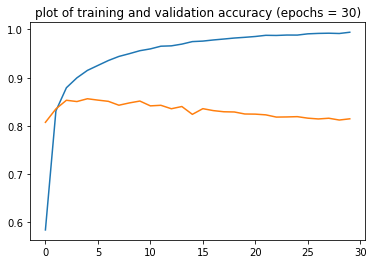

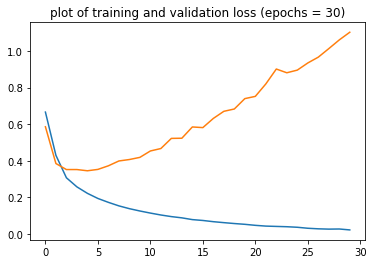

In [88]:
import matplotlib.pyplot as plt 

train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(len(train_acc))

plt.plot(epochs, train_acc, label = "Training Accuracy")
plt.plot(epochs, val_acc, label = "validation Accuracy")
plt.title("plot of training and validation accuracy (epochs = 30)")
plt.figure()

plt.plot(epochs, train_loss, label = "Training loss")
plt.plot(epochs, validation_loss, label = "validation loss")
plt.title("plot of training and validation loss (epochs = 30)")
plt.show()

In [89]:
reverse_word_index = dict([(value, key) for (key,value) in word_index.items()])

def decode_sentences(text):
    return " ".join([reverse_word_index.get(i, '?') for i in text])

In [90]:
decode_sentences(training_padded[0])

"former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?"

In [94]:
print(decode_sentences(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [95]:
#now i'll get the embedding - 
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(10000, 16)


In [96]:
import io 

out_v = io.open('vecs1.tsv', 'w', encoding='utf-8')
out_m = io.open('meta1.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

result - http://localhost:8888/view/Desktop/Screenshot%202021-10-19%20at%2010.23.37%20PM.png 